In [19]:
import matplotlib.pyplot as plt # plotting
import pandas as pd # data manipulation and analysis
import numpy as np # numerical computation
import pickle

import scipy
from scipy.interpolate import spline
from scipy.ndimage.filters import gaussian_filter1d
from statsmodels.nonparametric.smoothers_lowess import lowess
import random
import math

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

### load the data from pickled files

In [2]:
f0 = open("partitioned_features.pickle","rb")
feat_all = pickle.load(f0)
f0.close()


In [3]:
f1 = open("partitioned_features_defective.pickle","rb")
feat_defective = pickle.load(f1)
f1.close()

In [4]:
f2 = open("partitioned_features_good.pickle","rb")
feat_good = pickle.load(f2)
f2.close()

### quality check 1 - check if all data in good is labeled w/ 0 and all data w/ defective is labeled w/ 1

They passed the test :) 

In [5]:
for test in feat_defective:
    for pt in test:
        label = pt[-2]
        if label==0:
            print("Error")
            print(pt)
        elif label!=1:
            print("Error")

In [6]:
for test in feat_good:
    for pt in test:
        label = pt[-2]
        if label==1:
            print("Error")
            print(pt)
        elif label!=0:
            print("Error")

## Calculate all the means and statndard deviation

The methods below take as input a list of features - this is the data, normalised and chopped. The output is some feature of the time series, for instance it could be the mean, the standard deviation, the max, the min, the norm gradient mean etc. 

In [175]:
def the_means(feature_list):
    feat_means = []
    for i in feature_list:
        transposed = np.transpose(i)
        means = []
        for j in transposed:
            means.append(np.mean(j))
        feat_means.append(means)
    return feat_means

def the_stds(feature_list):
    feat_stds = []
    for i in feature_list:
        transposed = np.transpose(i)
        stds = []
        for j in transposed:
            stds.append(np.std(j))
        feat_stds.append(stds)
    return feat_stds

def the_max(feature_list):
    feat_max = []
    for i in feature_list:
        transposed = np.transpose(i)
        maxes = []
        for j in transposed:
            maxes.append(max(j))
        feat_max.append(maxes)
    return feat_max

def the_min(feature_list):
    feat_min = []
    for i in feature_list:
        transposed = np.transpose(i)
        mins1 = []
        for j in transposed:
            mins1.append(min(j))
        feat_min.append(mins1)
    return feat_min
        
def get_gradient(feature_list):# returns the gradient of everything
    feat_grad = []
    for i in feature_list:
        transposed = np.transpose(i)
        # find the gradient at each point
        gradients = []
        for j in range(len(transposed)):
            grad_feat = []
            for k in range(len(transposed[j])):
                if k>=1:
                    grad_feat.append(transposed[j][k]-transposed[j][k-1])
            gradients.append(grad_feat)
        feat_grad.append(np.transpose(gradients))
    return feat_grad
        
def non_zero_grad_mean45(feature_list):# 2d
    feature_grad = get_gradient(feature_list)
    non_zero_grad_means = []
    for i in feature_grad:
        transposed = np.transpose(i)
        non_zero_grad = [[],[]]
        for j in [4,5]:
            for k in range(len(transposed[j])):
                if transposed[j][k]!=0:
                    non_zero_grad[j-4].append(transposed[j][k])
        a0 = np.mean([abs(i) for i in non_zero_grad[0]])
        a1 = np.mean([abs(i) for i in non_zero_grad[0]])
        non_zero_grad_means.append([a0,a1])
    return non_zero_grad_means

def gradient_norm_mean(feature_list):
    feat_grad = get_gradient(feature_list)
        
    # we want a gradient (absolute value) mean as a feature
    feat_grad = map(abs,feat_grad)
    gradient_mean = the_means(feat_grad)
    
    return gradient_mean

def double_derivative_norm_mean(feature_list):# 10 D
    double_derivative = get_gradient(get_gradient(feature_list))
    
    # we want the absolute value mean of the double derivative
    double_derivative = map(abs,double_derivative)
    double_derivative_mean = the_means(double_derivative)
    
    return double_derivative_mean



# noticed that features 4, 5 and 6 are often 50 for many data points in a row, in other
# words the gradient is 0 quite alot. We therefore add two new features which are 
# 1) the number of data points where the gradient is 0 divided by the number of times the gradient is zero
# we do this for numbers 4, 5 and 6
def grad_new_features(feature_list):
    feature_grad = get_gradient(feature_list)
    new_features_list = []
    for i in feature_grad:
        transposed = np.transpose(i)
        new_feature = []
        for j in [4,5,6]:
            count=0
            for k in range(len(transposed[j])):
                if transposed[j][k]==0: count+=1
            try: new_feature.append(count/len(transposed[j]))
            except ZeroDivisionError: new_feature.append(0)
        new_features_list.append(new_feature)
    return new_features_list
        
# returns feature list of how many times the gradient changes sign
def turns(feature_list):
    feature_grad = get_gradient(feature_list)
    changes_sign_list = []
    for i in feature_grad:
        transposed = np.transpose(i)
        changes_sign = []
        for j in range(len(transposed)):
            count=0
            for k in range(1,len(transposed[j])):
                if (transposed[j][k]>0 and transposed[j][k-1]<=0) or (transposed[j][k]<=0 and transposed[j][k]>0):
                    count+=1
            try: changes_sign.append(count/len(transposed[j]))
            except ZeroDivisionError: changes_sign.append(0)
        changes_sign_list.append(changes_sign)
    return changes_sign_list


#feat_all_grad_means = gradient_mean(feat_all)

#feat_all_means = the_means(feat_all)

#new_features = grad_new_features(feat_all)
#dd = double_derivative_norm_mean(feat_all)
#turns_all = turns(feat_all)

"""
feat_all_means = the_means(feat_all)
feat_defective_means = the_means(feat_defective)
feat_good_means = the_means(feat_good)

feat_all_stds = the_stds(feat_all)
feat_defective_stds = the_means(feat_defective)
feat_good_stds = the_means(feat_good)

feat_all_max = the_max(feat_all)
feat_defective_max = the_max(feat_defective)
feat_good_max = the_max(feat_good)

feat_all_min = the_min(feat_all)
feat_defective_min = the_min(feat_defective)
feat_good_min = the_min(feat_defective)"""

'\nfeat_all_means = the_means(feat_all)\nfeat_defective_means = the_means(feat_defective)\nfeat_good_means = the_means(feat_good)\n\nfeat_all_stds = the_stds(feat_all)\nfeat_defective_stds = the_means(feat_defective)\nfeat_good_stds = the_means(feat_good)\n\nfeat_all_max = the_max(feat_all)\nfeat_defective_max = the_max(feat_defective)\nfeat_good_max = the_max(feat_good)\n\nfeat_all_min = the_min(feat_all)\nfeat_defective_min = the_min(feat_defective)\nfeat_good_min = the_min(feat_defective)'

### We do something similar using ARIMA, we fit the data series with model (1,1,0) because it's fast. This works only for 1,4,6

In [174]:
def feat_arima_coefs(feature_list):
    feat_arima = []
    # first 1
    for i in feature_list:
        transposed = np.transpose(i)
        series = transposed[1]
        model = ARIMA(series, order=(1,1,0))
        model_fit = model.fit(disp=0)
        
        params1 = model_fit.params[:]
        
        series = transposed[4]
        model = ARIMA(series, order=(1,1,0))
        model_fit = model.fit(disp=0)
        
        params4 = model_fit.params[:]
        
        serise = transposed[6]
        model = ARIMA(series, order=(1,1,0))
        model_fit = model.fit(disp=0)
        
        params6 = model_fit.params[:]
        
        feat_arima.append(list(params1)+list(params4)+list(params6))
        
    return feat_arima
        
        
#a = feat_arima_coefs(time_series_x)

#### function takes viet's normalised (or not normalized) time series list and returns a feature matrix

In [8]:
# import viet's time series
time_series_x = np.load('data_lstm/X_raw.npy')

In [176]:
def get_features_map(time_series,pickle_name="time_series_features.pickle",pickle=True):
    # means
    feat_means = the_means(time_series)# 10 D
    # stds
    feat_stds = the_stds(time_series)# 10 D
    # maxes
    feat_max = the_max(time_series)# 10 D
    # min
    feat_min = the_min(time_series)# 10 D
    # gradient mean
    feat_grad = gradient_norm_mean(time_series)# 10 D
    # new features from 4,5,6
    new_feat1 = grad_new_features(time_series)# 3 D
    # non zero grad 4,5
    non_zero_grad = non_zero_grad_mean45(time_series)# 2 D
    # the double derivative mean
    feat_dd = double_derivative_norm_mean(time_series)# 10 D
    # the number of times the gradient changes sign
    feat_changes_sign = turns(time_series)# 10 D
    
    # the arima stuff
    feat_arima = feat_arima_coefs(time_series)
    
    big_features_list = [feat_means,feat_stds,feat_max,feat_min,feat_grad,new_feat1,
                         non_zero_grad,feat_dd,feat_changes_sign,feat_arima]
    for i in big_features_list:
        try: print(len(i))
        except: print(i)
    #input()
    ###
    
    # first check that they are all the same length
    l = len(feat_means)
    for i in big_features_list:
        if len(i)!=l: raise Exception("features lists are not the same size, they should be")
        
    complete_features_list = big_features_list[0]
    for j in range(1,len(big_features_list)):
        for k in range(len(big_features_list[0])):
            complete_features_list[k] = complete_features_list[k]+big_features_list[j][k]
    
    #for j in big_features_list:
     #   if j==feat_means: complete_features_list=[j]
      #  else:
       #     for k in range(l):
        #        complete_features_list[k] = complete_features_list[k]+j[k]
    
    # pickle the data
    if pickle:
        np.array(complete_features_list).dump(open('data_lstm/x_feature_arima.npy', 'wb'))
    return complete_features_list
    
    
    
    



In [17]:
#print(feat_all_grad_means[100])

In [18]:
print(len(feat_all_stds))
print(len(feat_defective_stds))
print(len(feat_good_stds))
feat_all_stds[0]

470
166
304


[156.37173345474025,
 62.32149366866028,
 1.232999140272644,
 5.025814823312249,
 5.389884403292671,
 14.612273862705484,
 36.434891883195824,
 3.09237379284704,
 2.266874622624454,
 19.058937700983474,
 0.0,
 0.0]

## Fitting an ARIMA model

In [20]:
# import viets time series
time_series_x = np.load('data_lstm/X_raw.npy')

In [131]:
for i in time_series_x:
    series = np.transpose(i)[9]
    # fit model
    model = ARIMA(series, order=(1,1,0))
    model_fit = model.fit(disp=0)
    print("gd",end=" ")

gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd 

/home/steve/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/steve/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd 

/home/steve/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd 

/home/steve/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd 

/home/steve/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd 

/home/steve/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd 

/home/steve/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd gd 

/home/steve/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [98]:
print(len(time_series_x[1][1]))

10


In [130]:
for i in time_series_x:
    series = np.transpose(i)[1]
    # fit model
    model = ARIMA(series, order=(1,1,0))
    model_fit = model.fit(disp=0)
    print("gd",end="  ")

gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  gd  

(1,1,0) Works with 1,4,6

not 2,3,5,7,8,9

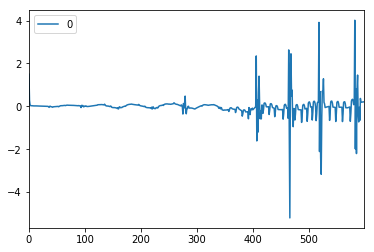

In [68]:
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()

In [69]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  599
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -419.276
Method:                       css-mle   S.D. of innovations              0.485
Date:                Sun, 29 Sep 2019   AIC                            852.551
Time:                        06:47:04   BIC                            883.318
Sample:                             1   HQIC                           864.529
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4761      1.310     -1.127      0.260      -4.044       1.092
ar.L1.D.y     -0.4636      0.039    -11.867      0.000      -0.540      -0.387
ar.L2.D.y      0.3426      0.040      8.578      0.0

In [79]:
model_fit

In [80]:
model_fit.params


array([-1.47610677, -0.46359603,  0.34260841,  0.41117322,  0.4129602 ,
        0.28746462])

## Plot them

In [10]:
# input is a feature index

def disp_feature_mean_etc(i):
    fam = [j[i] for j in feat_all_means]
    fas = [j[i] for j in feat_all_stds]
    fdm = [j[i] for j in feat_defective_means]
    fgm = [j[i] for j in feat_good_means]
    fds = [j[i] for j in feat_defective_stds]
    fgs = [j[i] for j in feat_good_stds]
    
    plt.figure(figsize=(12,12))

    t=0.8

    plt.subplot(431)
    plt.plot(np.linspace(0,1,len(fam)), fam,"x",alpha=t)
    plt.title("feat_all_means")

    plt.subplot(432)
    plt.plot(np.linspace(0,1,len(fdm)), fdm,"x",alpha=t)
    plt.title("feat_defective_means")


    plt.subplot(433)
    plt.plot(np.linspace(0,1,len(fgm)), fgm,"x",alpha=t)
    plt.title("feat_good_means")



    plt.subplot(434)
    plt.plot(np.linspace(0,1,len(fas)), fas,"x",alpha=t)
    plt.title("feat_all_stds")


    plt.subplot(435)
    plt.plot(np.linspace(0,1,len(fds)), fds,"x",alpha=t)
    plt.title("feat_defective_stds")


    plt.subplot(436)
    plt.plot(np.linspace(0,1,len(fgs)), fgs,"x",alpha=t)
    plt.title("feat_good_stds")

    plt.show()
    
    
disp_feature_mean_etc(0)

NameError: name 'feat_all_means' is not defined